## Test notebook for Data Management Acceptance Test Campaign 1
This test will be executed on the Rubin Science Platform Notebook Aspect at the Interim Data Facility, initialized with Science Pipelines release w_2022_32.

### Test case LVV-T84: Verify implementation of Bias Residual Image

Verify that DMS can construct a bias residual image that corrects for temporally-stable bias structures.
Verify that DMS can do this on demand.

In [60]:
from lsst.daf.butler import Butler

import matplotlib.pyplot as plt
import numpy as np
import os
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.obs.lsst as obs_lsst

from firefly_client import FireflyClient

#### Extract a small amount of data from the Object table:

In [3]:
# For DP0.2 data on the IDF:                                                                                                           
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

#### Convert the results to an astropy table, then write them in CSV, VOTable, and FITS formats

In [4]:
dataId = {'instrument': 'LSSTCam-imSim', 'detector': 78, 'visit': 60891, 'exposure':60891, 'band':'i'}

In [5]:
raw = butler.get('raw', dataId=dataId)
bias = butler.get('bias', dataId=dataId)

#### Extract a small amount of data from the DIAObject table:

In [7]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

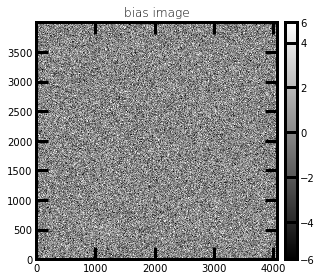

In [8]:
fig, ax = plt.subplots(1, 1)

display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(bias.image)
plt.title("bias image")

plt.tight_layout()
plt.show()

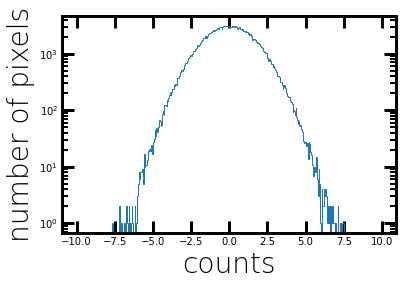

In [64]:
plt.hist(bias[0:500, 0:500].image.array.flat, bins=np.arange(-10, 10, 0.05), histtype='step')
plt.xlabel('counts')
plt.ylabel('number of pixels')
plt.semilogy()
plt.show()

#### Configure the IsrTask with most corrections disabled.

Note that the `.run` method of `IsrTask` requires the detector number and a camera object to be passed.

In [37]:
isr_config = IsrTask.ConfigClass()
isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doLinearize=False
isr = IsrTask(config=isr_config)
result = isr.run(raw, bias=bias,
                 detectorNum=raw.detector.getId(),
                 camera=obs_lsst.LsstCamImSim.getCamera()
                )

In [69]:
isr_config

lsst.ip.isr.isrTask.IsrTaskConfig(saveMetadata=True, saveLogOutput=True, datasetType='raw', useFallbackDate=False, expectWcs=True, fwhm=1.0, qa={'saveStats': True, 'flatness': {'meshX': 256, 'meshY': 256, 'doClip': True, 'clipSigma': 3.0, 'nIter': 3}, 'doWriteOss': False, 'doThumbnailOss': False, 'doWriteFlattened': False, 'doThumbnailFlattened': False, 'thumbnailBinning': 4, 'thumbnailStdev': 3.0, 'thumbnailRange': 5.0, 'thumbnailQ': 20.0, 'thumbnailSatBorder': 2}, doConvertIntToFloat=True, doSaturation=True, saturatedMaskName='SAT', saturation=nan, growSaturationFootprintSize=1, doSuspect=False, suspectMaskName='SUSPECT', numEdgeSuspect=0, edgeMaskLevel='DETECTOR', doSetBadRegions=True, badStatistic='MEANCLIP', doOverscan=True, overscan={'fitType': 'MEDIAN', 'order': 1, 'numSigmaClip': 3.0, 'maskPlanes': ['BAD', 'SAT'], 'overscanIsInt': True}, overscanFitType='MEDIAN', overscanOrder=1, overscanNumSigmaClip=3.0, overscanIsInt=True, overscanNumLeadingColumnsToSkip=0, overscanNumTrailin

In [63]:
print('  image       median     stddev    (of image pixel values)')
print('bias:       ', np.nanmedian(bias.image.array), np.nanstd(bias.image.array))
print('raw:        ', np.nanmedian(raw.image.array), np.nanstd(raw.image.array))
print('after bias: ', np.nanmedian(result.outputExposure.image.array), np.nanstd(result.outputExposure.image.array))

  image       median     stddev    (of image pixel values)
bias:        0.005981037 1.6216613
raw:         4054.4614 3701.2268
after bias:  4063.9893 441.7895


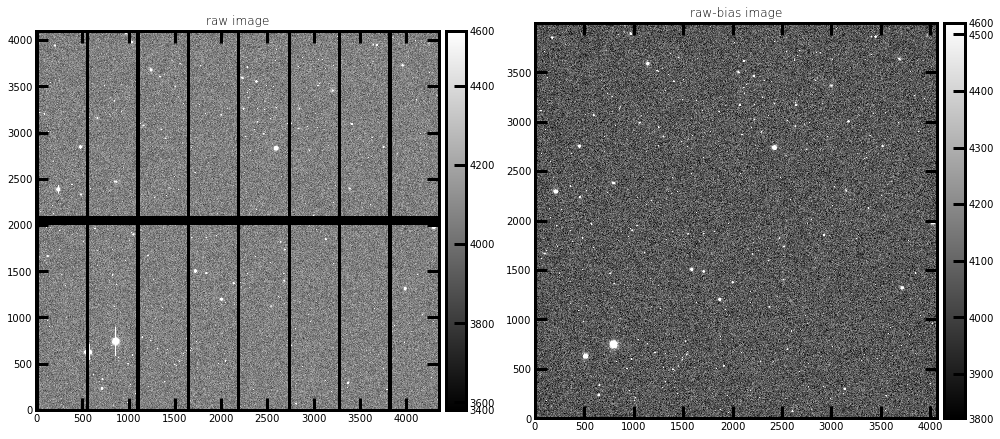

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(raw.image)
plt.title("raw image")

plt.sca(ax[1])
#display1 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(result.outputExposure.image)
plt.title("raw-bias image")

plt.tight_layout()
plt.show()

In [36]:
obs_lsst.LsstCamImSim.getCamera()

In [37]:
bias.detector

This matches the expected output. We have thus verified the exporting of various file formats from the Notebook Aspect.